In [4]:
# import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

In [5]:
# PATH = "/home/tukl/projects/Art-Classifier/art_classifier/data/wikipaintings_full"
PATH = "../../rasta/data/wikipaintings_small/"
# PATH = "../data/wikipaintings_small"
train_dir = os.path.join(PATH, 'wikipaintings_train')
validation_dir = os.path.join(PATH, 'wikipaintings_val')
test_dir = os.path.join(PATH, 'wikipaintings_test')

BATCH_SIZE = 16
IMG_SIZE = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 250 files belonging to 25 classes.


In [6]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 248 files belonging to 25 classes.


In [7]:
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                           shuffle=False,
                                                           batch_size=BATCH_SIZE,
                                                           image_size=IMG_SIZE)

Found 250 files belonging to 25 classes.


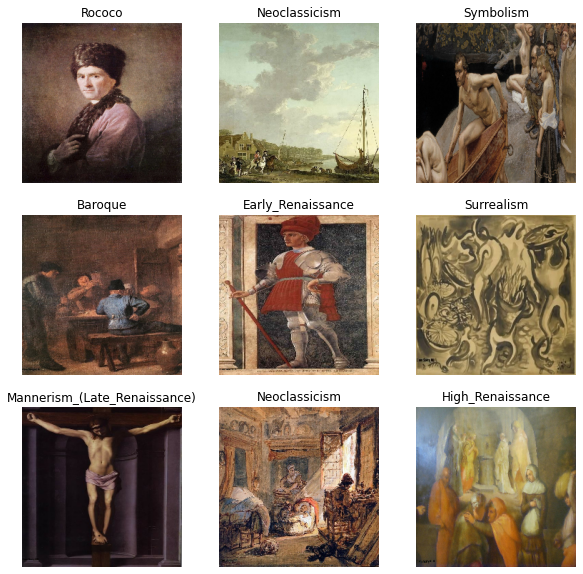

In [11]:
class_names = test_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [9]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

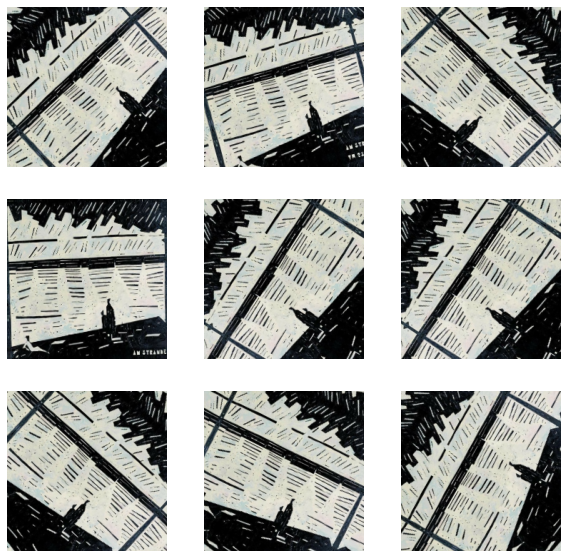

In [9]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [10]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

In [11]:

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights=None,
                                               )

In [12]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 7, 7, 2048)


In [ ]:

model.summary()

In [13]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 2048)


In [14]:
prediction_layer = tf.keras.layers.Dense(25)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(16, 25)


In [15]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=True)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [16]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

In [ ]:
# initial_epochs = 10

# loss0, accuracy0 = model.evaluate(validation_dataset)

In [ ]:
# print("initial loss: {:.2f}".format(loss0))
# print("initial accuracy: {:.2f}".format(accuracy0))

In [ ]:
initial_epochs = 6
metric = 'val_accuracy'
filepath="../my_models/resnet50_scratch_1.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor=metric, verbose=1, save_best_only=True, mode='max')
earlystopping = EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)
csv_logger = CSVLogger('../logs/resnet50_scratch_1.log',separator=",", append=True)
callbacks_list = [checkpoint,earlystopping,csv_logger]
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks=callbacks_list,
                    verbose=1)

Epoch 1/6
 5/16 [========>.....................] - ETA: 1:21 - loss: 3.8795 - accuracy: 0.0750

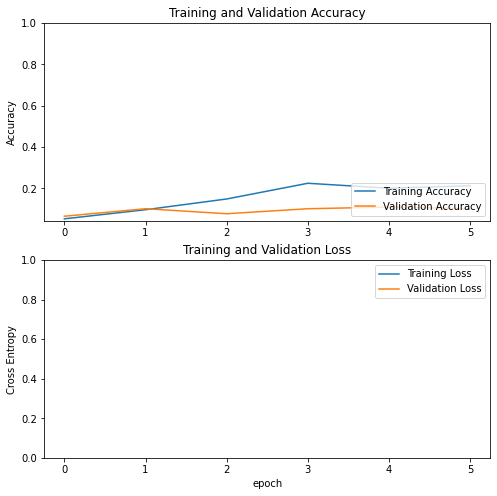

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:

# print("Number of layers in the base model: ", len(base_model.layers))


# fine_tune_at = 100


# for layer in base_model.layers[:fine_tune_at]:
#       layer.trainable = False

In [ ]:
# model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

In [ ]:
# len(model.trainable_variables)

In [ ]:
# fine_tune_epochs = 10
# total_epochs =  initial_epochs + fine_tune_epochs

# history_fine = model.fit(train_dataset,
#                          epochs=total_epochs,
#                          initial_epoch=history.epoch[-1],
#                          validation_data=validation_dataset)

In [ ]:
# acc += history_fine.history['accuracy']
# val_acc += history_fine.history['val_accuracy']

# loss += history_fine.history['loss']
# val_loss += history_fine.history['val_loss']

In [ ]:
# plt.figure(figsize=(8, 8))
# plt.subplot(2, 1, 1)
# plt.plot(acc, label='Training Accuracy')
# plt.plot(val_acc, label='Validation Accuracy')
# plt.ylim([0.8, 1])
# plt.plot([initial_epochs-1,initial_epochs-1],
#           plt.ylim(), label='Start Fine Tuning')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(2, 1, 2)
# plt.plot(loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
# plt.plot([initial_epochs-1,initial_epochs-1],
#          plt.ylim(), label='Start Fine Tuning')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.xlabel('epoch')
# plt.show()

In [14]:
model = tf.keras.models.load_model('../my_models/resnet50_imagenet.h5')
loss, accuracy = model.evaluate(train_dataset)
print('Test accuracy :', accuracy)

16/16 [==============================] - 31s 2s/step - loss: 2.3398 - accuracy: 0.2880
Test accuracy : 0.2879999876022339


In [ ]:

# image_batch, label_batch = test_dataset.as_numpy_iterator().next()
# predictions = model.predict_on_batch(image_batch).flatten()

# predictions = tf.nn.sigmoid(predictions)
# predictions = tf.where(predictions < 0.5, 0, 1)

# print('Predictions:\n', predictions.numpy())
# print('Labels:\n', label_batch)

# plt.figure(figsize=(10, 10))
# for i in range(9):
#   ax = plt.subplot(3, 3, i + 1)
#   plt.imshow(image_batch[i].astype("uint8"))
#   plt.title(class_names[predictions[i]])
#   plt.axis("off")